# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import (
    Circle,
    RegularPolygon,
    FancyArrowPatch,
    ArrowStyle,
    Rectangle,
)
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    NullFormatter,
)
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path("/home/alamson/DATA/Chromatin/")
mnt_path = Path.home() / "projects/DATA/Chromatin/"
ceph_path = Path.home() / "ceph/DATA/Chromatin/"

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
# plt.rcParams['image.cmap'] = 'emct8'
# plt.rcParams['image.cmap'] = 'warm'
plt.rcParams["image.cmap"] = "YlOrRd"
# plt.rcParams['image.cmap'] = 'twilight'
# plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'RdYlBu_r'

In [4]:
def plot_confidence_int(
    ax, time_arr, mean, std_dev, num_runs=12, color="b", ci=0.95, label="Mean", alpha=1.
):
    degrees_freedom = num_runs 
    confidence_interval = (
        stats.t.ppf((1 + ci) / 2.0, degrees_freedom) * std_dev / np.sqrt(num_runs)
    )

    _ = ax.plot(time_arr, mean, label=label, color=color, alpha=alpha)
    _ = ax.fill_between(
        time_arr,
        mean - confidence_interval,
        mean + confidence_interval,
        color=color,
        alpha=0.1,
    )

In [5]:
# Functions
def free_energy_droplet(Ld, mu, alpha, gamma):
    return -mu * alpha * Ld + gamma * 4.0 * np.pi * np.power(
        3.0 * alpha * Ld / (4 * np.pi), 2.0 / 3.0
    )


def free_energy_polymer(Ld, Ltot, Lsep, kappa):
    eps = Ltot - Ld
    return (
        0.25
        * kappa
        * ((eps / (1.0 - (Lsep / eps))) - Lsep + 2.0 * ((Lsep * Lsep) / eps) - eps)
    )


def tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return free_energy_droplet(Ld, mu, alpha, gamma) + free_energy_polymer(
        Ld, Ltot, Lsep, kappa
    )


def free_energy_deriv(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return -mu * alpha + (1.0 / 12.0) * (
        8.0 * np.power(6.0 * alpha, 2.0 / 3.0) * gamma * np.power(np.pi / Ld, 1.0 / 3.0)
        + 3.0
        * kappa
        * (Lsep**2)
        * (2.0 / np.power(Ld - Ltot, 2.0) + 1.0 / np.power(Lsep + Ld - Ltot, 2.0))
    )


def length_prob_unnorm(Ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=1.0 / 0.0041):
    return np.exp(-beta * tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
    # return tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)


def partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=1.0 / 0.0041):
    return quad(
        lambda Ld: np.exp(
            -beta * tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)
        ),
        0,
        Ltot - (Lsep * 1.001),
    )

## Figure 2

7201
7201
7201
7201
7201
1440


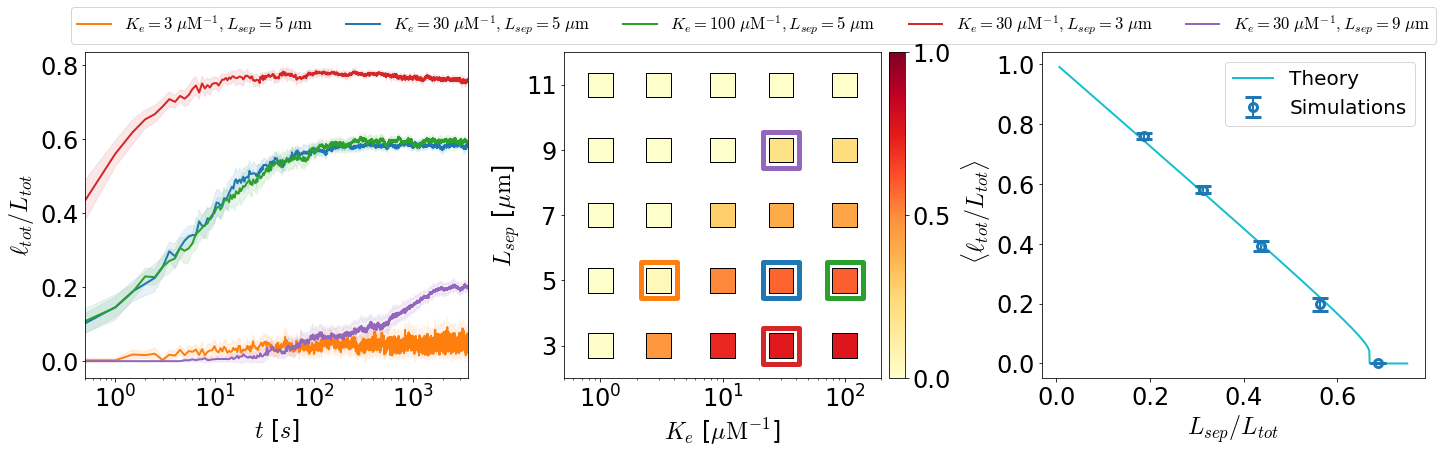

In [32]:
labels_to_graph_dict = {
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    # r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}
# colors = ['C1', 'C0','C2', 'C3', 'C4', 'C5', 'C6']
colors = ['C1', 'C0','C2', 'C3', 'C4']

fig = plt.figure(figsize=(24, 6))
gs = gridspec.GridSpec(1,9)

axarr = []
axarr +=[fig.add_subplot(gs[0,:3] )]
axarr +=[fig.add_subplot(gs[0,3:6])]
axarr +=[fig.add_subplot(gs[0,6:])]

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )
    _ = axarr[0].set_xscale("log")
    _ = axarr[0].set_ylabel("$\ell_{tot} / L_{tot}$")
    _ = axarr[0].set_xlabel("$t$ [$s$]")

_ = axarr[0].set_xlim(5e-1, 3600)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)

## Draw boxes around the selected points

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    # (data_arr[:,0] == 5.0) & (data_arr[:,1] == 10),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    # (data_arr[:,0] == 7.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
]


# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

# Graph outlining boxes
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1300,
    marker="s",
    edgecolors=color_array,
    linewidths=5,
)

## Condensed fraction graph
_ = axarr[1].set_xscale("log")
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=600,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[1],
    pad=0.02,
    # label=r" $\langle \ell_{tot}/L_{tot} \rangle$",
    # label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)
cb1.set_ticks([0, 0.5, 1])


_ = axarr[1].set_xlim(0.5, 200)
_ = axarr[1].set_ylim(2, 12)

_ = axarr[1].set_ylabel(r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[1].set_xlabel(r"$K_e$ [$\mu {\rm M}^{-1}$]")

_ = axarr[1].set_xticks([1,10,100])
_ = axarr[1].set_yticks([3,5,7,9,11])


## Comparison with theory from equilibrium model

mu = 4.1  # Free energy per volume pN/um^2
alpha = 0.05  # Condensate packing factor um^2
gamma = 0.15  # Surface tension pN/um
kappa = 0.0822  # Filament flexibility pN
Ltot = 16.0  # Total length of the polymer um

beta = 1.0 / 0.0041
# fig, axarr = plt.subplots(1, 1, figsize=(5, 5))


# Get theoretical results
lsep_arr = np.linspace(0.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size)
for i, lsep in enumerate(lsep_arr):
    bound = 0.1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += 0.5
    if bound > Ltot - (lsep * 1.0000001):
        ld_max_prob[i] = 0.0
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(
        free_energy_deriv,
        method="brentq",
        bracket=[bound, Ltot - (lsep * 1.0000001)],
        args=(Ltot, lsep, mu, alpha, gamma, kappa),
    )
    ld_max_prob[i] = result.root
_ = axarr[2].plot(lsep_arr / Ltot, ld_max_prob / Ltot, label="Theory", color="C9")
_ = axarr[2].set_xlabel(r"$L_{sep}/L_{tot}$")
_ = axarr[2].set_ylabel(r" $\langle \ell_{tot}/L_{tot} \rangle$"),

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs["Ke"], h5_data.attrs["pin_dist"]
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size // 2 :, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size // 2 :, 1].mean()]

    _ = axarr[2].errorbar(
        np.array(pin_dist_arr) / 16.0,
        np.array(beads_num_arr) / 1600.0,
        yerr=np.array(beads_std_arr) / 1600.0,
        fmt="o",
        markeredgewidth=3,
        markeredgecolor="C0",
        markersize=8,
        markerfacecolor="none",
        capsize=8,
        label="Simulations",
    )
_ = axarr[0].legend(ncol=5, bbox_to_anchor=(-0.06, 1),
              loc='lower left', fontsize='small')
_ = axarr[2].legend()
fig.subplots_adjust(hspace=0.3, wspace=1.5)

fig.savefig("Figure2/fig2_cond_tot.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig2_cond_tot.png", dpi=300, bbox_inches="tight")


# Collect data

In [6]:
slice_path = (
    ceph_path
    / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations"
)

pin_ke_data_dict = {}


def parse_params(param_dir):
    data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
    with h5py.File(data_path, "r") as h5_data:
        run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
        prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

    return run_params["pinDist"], prot_params["proteins"][0]["Ke"][1]


for param_dir in slice_path.glob("*"):
    print(param_dir)
    pin_dist, Ke = parse_params(param_dir)
    if pin_dist not in pin_ke_data_dict:
        pin_ke_data_dict[pin_dist] = {}

    sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

    num_runs = len(sd_h5_file_lst)
    try: 
        min_run_length = min(
            [len(h5py.File(h5p, "r")["time"]) for h5p in sd_h5_file_lst]
        )
    except:
        print(f"Error occured in param dir", param_dir)
        continue
    with h5py.File(sd_h5_file_lst[0], "r") as h5d:
        time_arr = h5d["time"][ss_ind:end_ind]
        nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

    avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
    avg_max_num_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
    avg_var_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
    avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

    for ih, h5d in enumerate(sd_h5_file_lst):
        try:
            h5_clust_file = h5d.parent / "cluster_analysis.h5"
            with h5py.File(h5_clust_file, "r") as h5_data:
                cluster_grp = h5_data["clusters"]
                time_grp_list = sorted(
                    cluster_grp.values(), key=lambda x: x.attrs["time"]
                )
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]

            # assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [
                    clust for clust in clust_grp if len(clust.part_ids) > part_min
                ]

                num_beads = 0
                max_beads = 0
                clust_size_list = []
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)
                    clust_size_list += [len(clust.part_ids)]
                    max_beads = max(max_beads, len(clust.part_ids))

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads
                avg_max_num_beads_arr[ih, c] = max_beads
                avg_var_clust_arr[ih, c] = np.var(clust_size_list)
        except:
            print(f"Error occured at", h5d.parent)

    num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
    num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
    num_clust_mean = avg_num_clust_arr.mean(axis=0)
    num_clust_std_dev = avg_num_clust_arr.std(axis=0)
    max_num_bead_mean = avg_max_num_beads_arr.mean(axis=0)
    max_num_bead_std_dev = avg_max_num_beads_arr.std(axis=0)
    var_clust_mean = avg_var_clust_arr.mean(axis=0)
    var_clust_std_dev = avg_var_clust_arr.std(axis=0)

    pin_ke_data_dict[pin_dist][Ke] = [
        num_bead_mean,
        num_bead_std_dev,
        num_clust_mean,
        num_clust_std_dev,
        max_num_bead_mean,
        max_num_bead_std_dev,
        var_clust_mean,
        var_clust_std_dev,
        num_runs,
    ]


/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin11.0um


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/D

OSError: Unable to open file (bad object header version number)

In [ ]:
# Store pin_ke_data_dict as an hdf5 file
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "w") as h5d:
    _ = h5d.create_dataset("time", data=time_arr)
    for pin_dist, ke_data in pin_ke_data_dict.items():
        for ke, data in ke_data.items():
            dset = h5d.create_dataset(
                f"Pin{pin_dist:.1f}um_Ke{ke:.3g}", data=np.vstack(data[:-1]).T
            )
            dset.attrs["pin_dist"] = pin_dist
            dset.attrs["Ke"] = ke
            dset.attrs["num_runs"] = data[-1]

# Supplement figures

In [33]:
data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100"
vmax = 40 # Max colorbar value in kymographs

h5_list = list(data_path.glob('simulations/*/s1/analysis/raw*.h5'))
print(len(h5_list))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        prot_params = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        contact_file = h5d.parent / 'contact_analysis.h5'

        pin_dist = run_params['pinDist']
        Ke = prot_params['proteins'][0]['Ke'][1]

        if pin_dist not in data_dict:
            data_dict[pin_dist] = {}
        data_dict[pin_dist][Ke]= contact_file

pin_dist_list = sorted(data_dict.keys())
print("pin_dist_list: ", pin_dist_list)
ke_list = sorted(data_dict[pin_dist].keys())
print("ke_list: ", ke_list)

25
pin_dist_list:  [3.0, 5.0, 7.0, 9.0, 11.0]
ke_list:  [1.0, 3.0, 10.0, 30.0, 100.0]


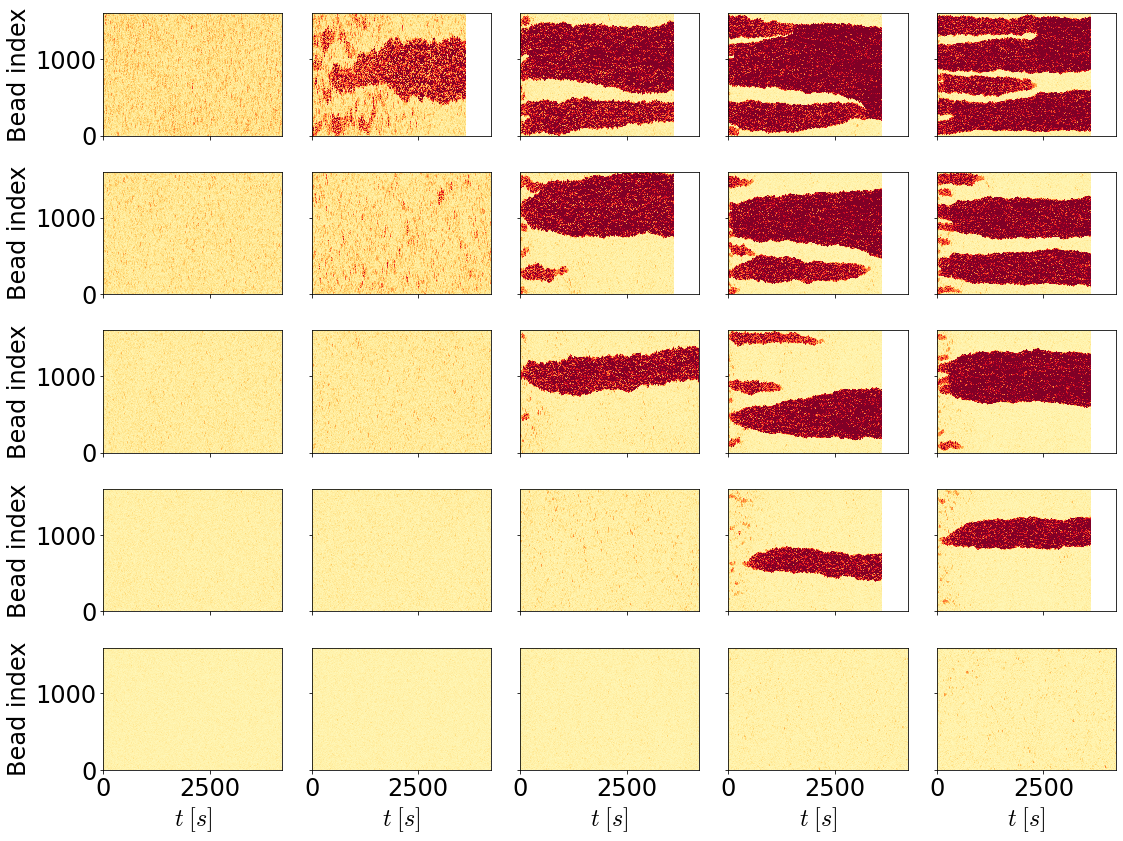

In [35]:
fig, axarr = plt.subplots(len(pin_dist_list),len(ke_list), figsize=(16, 12), sharex=True, sharey=True)
for i, pin_dist in enumerate(pin_dist_list):
    for j, ke in enumerate(ke_list):
        try: 
            with h5py.File(data_dict[pin_dist][ke], 'r') as h5_data:
                time_arr = h5_data['time'][...]
                contact_kymo = h5_data['contact_kymo'][...]
    
            cgf.plot_contact_kymo(fig, axarr[i,j], time_arr, 
                                  contact_kymo, vmax=vmax, label_flag=False)
        except:
            print(f"Error occured at pin_dist: {pin_dist}, ke: {ke}")
            # raise
            pass

axarr[0,0].invert_yaxis()

for axarr_row in axarr:
    _ = axarr_row[0].set_ylabel('Bead index')

for bottom_row in axarr[-1]:
    _ = bottom_row.set_xlabel('$t\;[s]$')

fig.tight_layout()

fig.savefig("Figure2/fig2_supp_contact_kymos.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig2_supp_contact_kymo.png", dpi=300, bbox_inches="tight")

# Old

3601
3601
3601
3601
3601
720


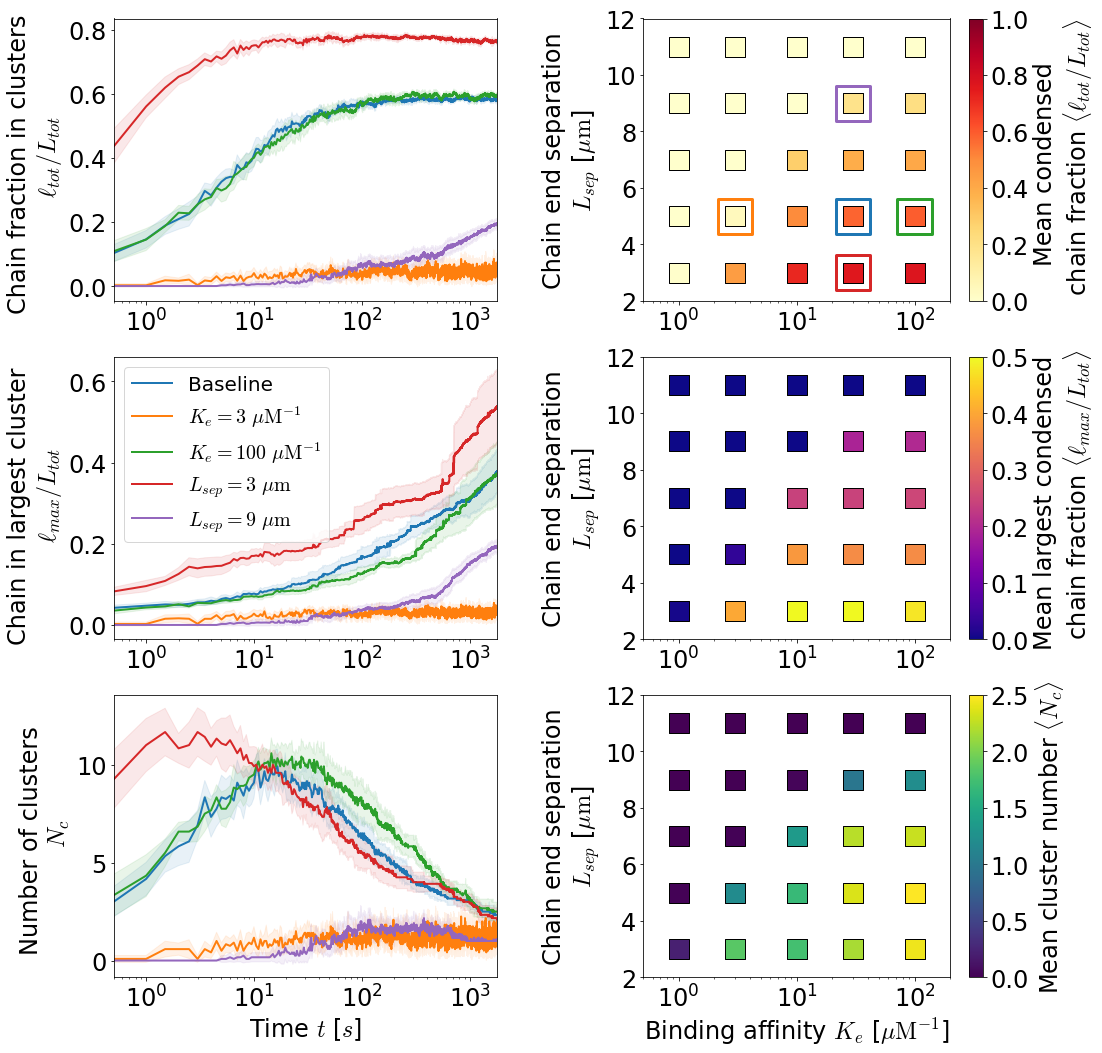

In [ ]:
labels_to_graph_dict = {
    "Baseline": "Pin5.0um_Ke30/",
    r"$K_e = 3~\mu {\rm M}^{-1}$": "Pin5.0um_Ke3/",
    r"$K_e = 100~\mu {\rm M}^{-1}$": "Pin5.0um_Ke100",
    r"$L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}

fig = plt.figure(figsize=(16, 15))
gs = gridspec.GridSpec(3,6)

axarr = []
axarr +=[fig.add_subplot(gs[0,:3] )]
axarr +=[fig.add_subplot(gs[1,:3], sharex=axarr[0])]
axarr +=[fig.add_subplot(gs[2,:3], sharex=axarr[0])]
axarr +=[fig.add_subplot(gs[0,3:])]
axarr +=[fig.add_subplot(gs[1,3:], sharex=axarr[3], sharey=axarr[3])]
axarr +=[fig.add_subplot(gs[2,3:], sharex=axarr[3], sharey=axarr[3])]

tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        # num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            num_runs,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0].set_ylabel("Chain fraction in clusters \n $\ell_{tot} / L_{tot}$")
    _ = axarr[0].set_xscale("log")

    _ = axarr[1].set_ylabel(
        "Chain in largest cluster  \n $\ell_{max} / L_{tot}$"
    )
    _ = axarr[1].legend(loc="upper left", bbox_to_anchor=(0, 1.0))

    _ = axarr[2].set_ylabel("Number of clusters \n $N_c$")
    _ = axarr[2].set_xlabel("Time $t$ [$s$]")
_ = axarr[0].set_xlim(5e-1, 1800)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
]

# Define the color for each condition
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

_ = axarr[3].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1200,
    marker="s",
    edgecolors=color_array,
    linewidths=3,
)
## Condensed fraction graph
_ = axarr[3].set_xscale("log")
_ = axarr[3].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=400,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[3],
    label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)

## Max cluster fraction
msc = axarr[4].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 6] / 1600,
    cmap="plasma",
    vmin=0,
    vmax=0.5,
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=0.5), cmap="plasma"),
    ax=axarr[4],
    label="Mean largest condensed \n chain fraction"
    + r" $\langle \ell_{max}/L_{tot} \rangle$",
)

## Number of cluster graph

sc = axarr[5].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 4],
    cmap="viridis",
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

# Create a colorbar
cb2 = fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=int(np.max(data_arr[:, 4])) + 0.5),
        cmap="viridis",
    ),
    ax=axarr[5],
    label=r"Mean cluster number $\langle N_c \rangle$",
)

_ = axarr[3].set_xlim(0.5, 200)
_ = axarr[3].set_ylim(2, 12)

for ax in axarr[3:]:
    # _ = ax.set_xlabel(r"Binding affinity [$\mu {\rm M}^{-1}$]")
    _ = ax.set_ylabel(r"Chain end separation" + "\n" + r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[5].set_xlabel(r"Binding affinity $K_e$ [$\mu {\rm M}^{-1}$]")

fig.tight_layout()
fig.savefig("Figure2/fig2_combined.png", dpi=300, bbox_inches="tight")


7201
7201
7201
7201
7201
1440


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


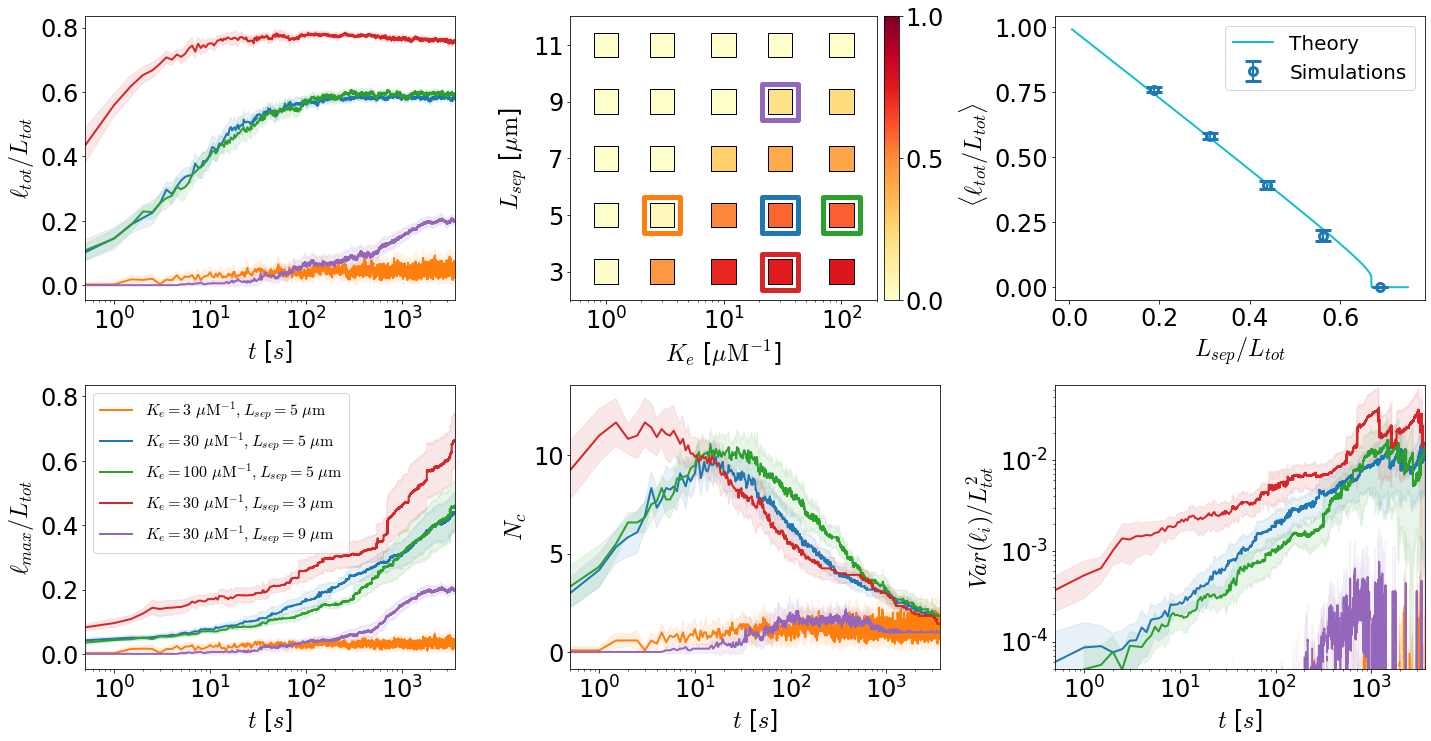

In [ ]:
labels_to_graph_dict = {
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}
colors = ['C1', 'C0','C2', 'C3', 'C4']

fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,9)

axarr = []
axarr +=[fig.add_subplot(gs[0,:3] )]
axarr +=[fig.add_subplot(gs[0,3:6])]
axarr +=[fig.add_subplot(gs[0,6:])]
axarr +=[fig.add_subplot(gs[1,:3], sharex=axarr[0], sharey=axarr[0] )]
axarr +=[fig.add_subplot(gs[1,3:6], sharex=axarr[0])]
axarr +=[fig.add_subplot(gs[1,6:], sharex=axarr[0])]
# axarr +=[fig.add_subplot(gs[1,6:], sharex=axarr[0])]

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[3],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[4],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[5],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")
    _ = axarr[0].set_ylabel("$\ell_{tot} / L_{tot}$")

    _ = axarr[3].set_ylabel( "$\ell_{max} / L_{tot}$")
    _ = axarr[3].set_ylabel(
        "$\ell_{max} / L_{tot}$"
    )
    
    _ = axarr[5].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[5].set_ylim(.00005)
    _ = axarr[5].set_yscale("log")

    _ = axarr[4].set_ylabel("$N_c$")
    _ = axarr[0].set_xlabel("$t$ [$s$]")
    _ = axarr[3].set_xlabel("$t$ [$s$]")
    _ = axarr[4].set_xlabel("$t$ [$s$]")
    _ = axarr[5].set_xlabel("$t$ [$s$]")
_ = axarr[0].set_xlim(5e-1, 3600)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)

## Draw boxes around the selected points

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
]

# Define the color for each condition
colors = ['C1', 'C0','C2', 'C3', 'C4']

# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

# Graph outlining boxes
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1300,
    marker="s",
    edgecolors=color_array,
    linewidths=5,
)

## Condensed fraction graph
_ = axarr[1].set_xscale("log")
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=600,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[1],
    pad=0.02,
    # label=r" $\langle \ell_{tot}/L_{tot} \rangle$",
    # label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)
cb1.set_ticks([0, 0.5, 1])


_ = axarr[1].set_xlim(0.5, 200)
_ = axarr[1].set_ylim(2, 12)

_ = axarr[1].set_ylabel(r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[1].set_xlabel(r"$K_e$ [$\mu {\rm M}^{-1}$]")

_ = axarr[1].set_xticks([1,10,100])
_ = axarr[1].set_yticks([3,5,7,9,11])


## Comparison with theory from equilibrium model

mu = 4.1  # Free energy per volume pN/um^2
alpha = 0.05  # Condensate packing factor um^2
gamma = 0.15  # Surface tension pN/um
kappa = 0.0822  # Filament flexibility pN
Ltot = 16.0  # Total length of the polymer um

beta = 1.0 / 0.0041
# fig, axarr = plt.subplots(1, 1, figsize=(5, 5))


# Get theoretical results
lsep_arr = np.linspace(0.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size)
for i, lsep in enumerate(lsep_arr):
    bound = 0.1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += 0.5
    if bound > Ltot - (lsep * 1.0000001):
        ld_max_prob[i] = 0.0
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(
        free_energy_deriv,
        method="brentq",
        bracket=[bound, Ltot - (lsep * 1.0000001)],
        args=(Ltot, lsep, mu, alpha, gamma, kappa),
    )
    ld_max_prob[i] = result.root
_ = axarr[2].plot(lsep_arr / Ltot, ld_max_prob / Ltot, label="Theory", color="C9")
_ = axarr[2].set_xlabel(r"$L_{sep}/L_{tot}$")
_ = axarr[2].set_ylabel(r" $\langle \ell_{tot}/L_{tot} \rangle$"),

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs["Ke"], h5_data.attrs["pin_dist"]
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size // 2 :, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size // 2 :, 1].mean()]

    _ = axarr[2].errorbar(
        np.array(pin_dist_arr) / 16.0,
        np.array(beads_num_arr) / 1600.0,
        yerr=np.array(beads_std_arr) / 1600.0,
        fmt="o",
        markeredgewidth=3,
        markeredgecolor="C0",
        markersize=8,
        markerfacecolor="none",
        capsize=8,
        label="Simulations",
    )

_ = axarr[2].legend()
_ = axarr[3].legend(fontsize=16)
# _ = axarr[4].legend(loc='center left', bbox_to_anchor=(1.05, .5))
# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)
fig.subplots_adjust(hspace=0.3, wspace=2.5)
# fig.tight_layout()

fig.savefig("Figure2/fig2_combined.png", dpi=300, bbox_inches="tight")


7201
7201
7201
7201
7201
1440


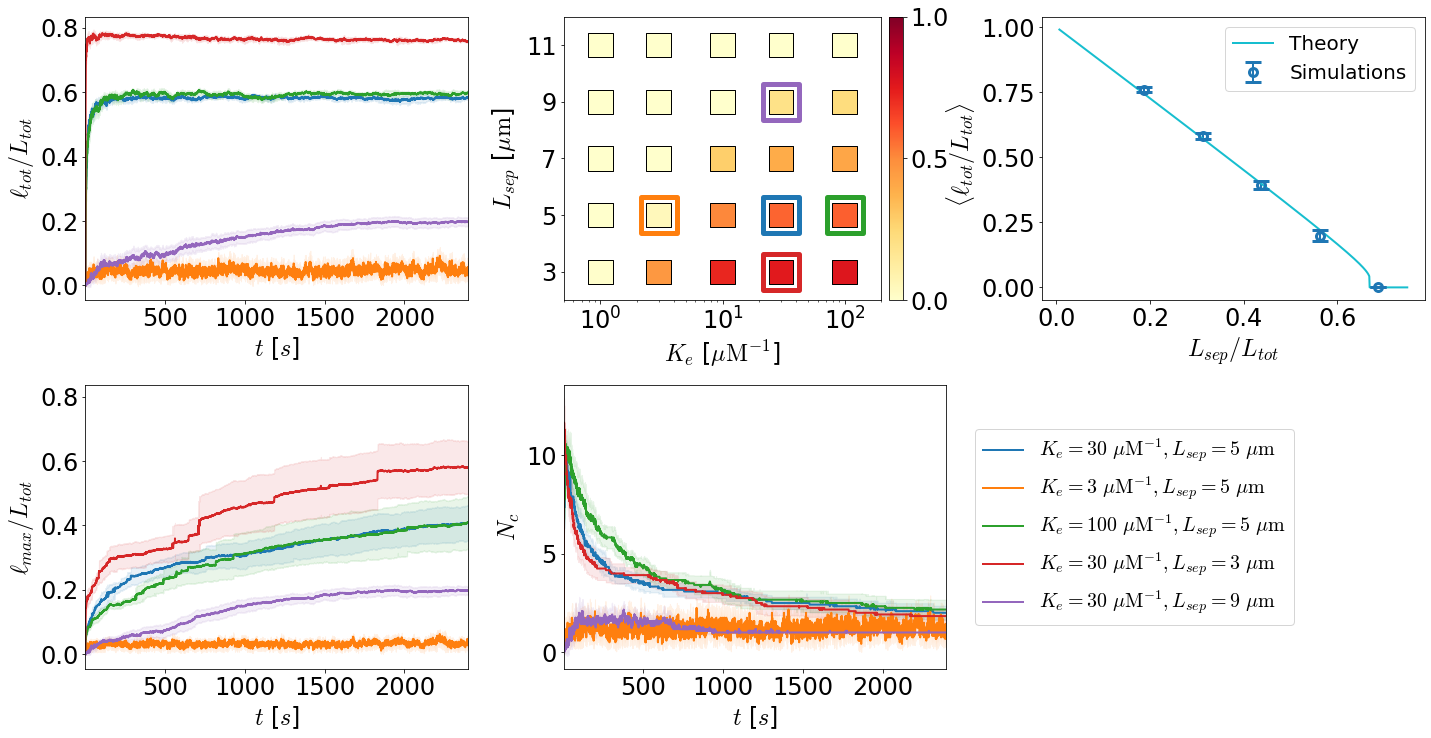

In [ ]:
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}

fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,9)

axarr = []
axarr +=[fig.add_subplot(gs[0,:3] )]
axarr +=[fig.add_subplot(gs[0,3:6])]
axarr +=[fig.add_subplot(gs[0,6:])]
axarr +=[fig.add_subplot(gs[1,:3], sharex=axarr[0], sharey=axarr[0] )]
axarr +=[fig.add_subplot(gs[1,3:6], sharex=axarr[0])]
# axarr +=[fig.add_subplot(gs[1,6:], sharex=axarr[0])]

tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        # num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[3],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            num_runs,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[4],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

    # _ = axarr[0].set_ylabel("Chain fraction in clusters \n $\ell_{tot} / L_{tot}$")
    _ = axarr[0].set_ylabel("$\ell_{tot} / L_{tot}$")
    # _ = axarr[0].set_xscale("log")

    _ = axarr[3].set_ylabel(
        "$\ell_{max} / L_{tot}$"
        # "Chain in largest cluster  \n $\ell_{max} / L_{tot}$"
    )
    # _ = axarr[3].legend(loc="upper left", bbox_to_anchor=(0, 1.0))
    # _ = axarr[4].legend(loc="upper left", bbox_to_anchor=(0, 1.0))
    

    _ = axarr[4].set_ylabel("$N_c$")
    # _ = axarr[2].set_ylabel("Number of clusters \n $N_c$")
    # _ = axarr[2].set_xlabel("Time $t$ [$s$]")
    _ = axarr[0].set_xlabel("$t$ [$s$]")
    _ = axarr[3].set_xlabel("$t$ [$s$]")
    _ = axarr[4].set_xlabel("$t$ [$s$]")
_ = axarr[0].set_xlim(5e-1, 2400)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
]

# Define the color for each condition
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1300,
    marker="s",
    edgecolors=color_array,
    linewidths=5,
)
## Condensed fraction graph
_ = axarr[1].set_xscale("log")
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=600,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[1],
    pad=0.02,
    # label=r" $\langle \ell_{tot}/L_{tot} \rangle$",
    # label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)
cb1.set_ticks([0, 0.5, 1])


_ = axarr[1].set_xlim(0.5, 200)
_ = axarr[1].set_ylim(2, 12)

# for ax in axarr[3:]:
#     # _ = ax.set_xlabel(r"Binding affinity [$\mu {\rm M}^{-1}$]")
#     # _ = ax.set_ylabel(r"Chain end separation" + "\n" + r"$L_{sep}$ [$\mu {\rm m}$]")
#     _ = ax.set_ylabel(r"$L_{sep}$ [$\mu {\rm m}$]")
# _ = axarr[5].set_xlabel(r"Binding affinity $K_e$ [$\mu {\rm M}^{-1}$]")
_ = axarr[1].set_ylabel(r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[1].set_xlabel(r"$K_e$ [$\mu {\rm M}^{-1}$]")

_ = axarr[1].set_xticks([1,10,100])
_ = axarr[1].set_yticks([3,5,7,9,11])


mu = 4.1  # Free energy per volume pN/um^2
alpha = 0.05  # Condensate packing factor um^2
gamma = 0.15  # Surface tension pN/um
kappa = 0.0822  # Filament flexibility pN
Ltot = 16.0  # Total length of the polymer um

beta = 1.0 / 0.0041
# fig, axarr = plt.subplots(1, 1, figsize=(5, 5))


# Get theoretical results
lsep_arr = np.linspace(0.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size)
for i, lsep in enumerate(lsep_arr):
    bound = 0.1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += 0.5
    if bound > Ltot - (lsep * 1.0000001):
        ld_max_prob[i] = 0.0
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(
        free_energy_deriv,
        method="brentq",
        bracket=[bound, Ltot - (lsep * 1.0000001)],
        args=(Ltot, lsep, mu, alpha, gamma, kappa),
    )
    ld_max_prob[i] = result.root
_ = axarr[2].plot(lsep_arr / Ltot, ld_max_prob / Ltot, label="Theory", color="C9")
# _ = axarr.set_xlabel(r"Chain end separation $L_{sep}/L_{tot}$")
_ = axarr[2].set_xlabel(r"$L_{sep}/L_{tot}$")
_ = axarr[2].set_ylabel(r" $\langle \ell_{tot}/L_{tot} \rangle$"),
# _ = axarr[2].set_ylabel("$\ell_{tot} / L_{tot}$")
# _ = axarr.set_ylabel(r"Total condensed length $\ell_{tot}/L_{tot}$")

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs["Ke"], h5_data.attrs["pin_dist"]
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size // 2 :, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size // 2 :, 1].mean()]

    _ = axarr[2].errorbar(
        np.array(pin_dist_arr) / 16.0,
        np.array(beads_num_arr) / 1600.0,
        yerr=np.array(beads_std_arr) / 1600.0,
        fmt="o",
        markeredgewidth=3,
        markeredgecolor="C0",
        markersize=8,
        markerfacecolor="none",
        capsize=8,
        label="Simulations",
    )

_ = axarr[2].legend()
_ = axarr[4].legend(loc='center left', bbox_to_anchor=(1.05, .5))
fig.subplots_adjust(hspace=0.3, wspace=1.5)
# fig.tight_layout()

# fig.savefig("Figure2/fig2_combined.png", dpi=300, bbox_inches="tight")
